In [66]:
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from pathlib import Path
import pandas as pd
import shap
import time
import os
import wfdb
from pathlib import Path
import re 
from collections import defaultdict
import matplotlib.pyplot as plt


class Patient:
    def __init__(self):
        self.studies = []
        self.label = []
    def __str__(self) -> str:
        return f"studies : {len(self.studies)} \n label : {len(self.label)} "

folder_path = Path('physionet.org/files/neurocritical-pediatric/1.0.0/waves')
header = [('ABP', float), ('CBFV', float)]
patient_static_map = defaultdict(Patient)

In [67]:
def normalize_data(data):
    data_array = data.view((data.dtype[0], len(data.dtype.names)))

    min_vals = np.min(data_array, axis=0)
    max_vals = np.max(data_array, axis=0)
    normalized_data = (data_array - min_vals) / (max_vals - min_vals)
    return normalized_data

In [68]:
def process_time_series(folder_path, header):
    for filename in folder_path.glob('*.dat'):  # Ensure we process only .dat files
        
        entity = filename.stem.split("_")
        id = entity[0][7:]        
        # Read the data record
        record = wfdb.rdrecord(str(filename.with_suffix('')), sampfrom=0)
        data = np.empty(record.sig_len, dtype=header)
        temp_labels = []
        
        for i, signal in enumerate(record.p_signal.T):
            
            if i == 0:
                data['ABP'] = signal
            elif i == 1:
                temp_labels = signal
            else:
                data['CBFV'] = signal

        # normalized = normalize_data(data)
        patient_static_map[id].studies.append(data)
        patient_static_map[id].label.append(temp_labels)

process_time_series(folder_path, header)
for key in patient_static_map:
    print(patient_static_map[key])

studies : 11 
 label : 11 
studies : 33 
 label : 33 
studies : 3 
 label : 3 
studies : 12 
 label : 12 
studies : 18 
 label : 18 
studies : 3 
 label : 3 
studies : 8 
 label : 8 
studies : 8 
 label : 8 
studies : 8 
 label : 8 
studies : 10 
 label : 10 
studies : 12 
 label : 12 
studies : 10 
 label : 10 


In [69]:
import numpy as np
from scipy.signal import periodogram, find_peaks
from scipy.optimize import least_squares

def estimate_icp(abp, cbfv, fs):
    """
    Estimate ICP using a spectral approach from ABP and CBFV waveforms.
    
    Parameters:
    abp (numpy.array): The arterial blood pressure waveform.
    cbfv (numpy.array): The cerebral blood flow velocity waveform.
    fs (float): Sampling frequency of the waveforms.
    
    Returns:
    float: Estimated mean ICP value.
    """
    # Compute power spectral densities (PSD) of ABP and CBFV
    freqs, psd_abp = periodogram(abp, fs)
    _, psd_cbfv = periodogram(cbfv, fs)
    
    # Identify dominant peaks in the PSD of ABP and CBFV
    peaks_abp, _ = find_peaks(psd_abp)
    peaks_cbfv, _ = find_peaks(psd_cbfv)
    
    #Eq (4)
    def model_func(v, omega, psd_abp, psd_cbfv):
        R, C, L = v
        model_psd = (1/R**2 + (omega*C)**2) / ((1 - omega**2*L*C)**2 + (omega*L/R)**2)
        return psd_cbfv - psd_abp * model_psd
    
    # Initial guess for R, C, L
    initial_guess = [1.0, 1e-6, 1e-3]
    min_peaks = min(len(peaks_abp), len(peaks_cbfv))
    omega = freqs[peaks_cbfv[:min_peaks]]
    # best-fitting R, C, L
    result = least_squares(model_func, initial_guess, args=(omega, psd_abp[peaks_abp[:min_peaks]], psd_cbfv[peaks_cbfv[:min_peaks]]))
    R, C, L = result.x

    pw = np.mean(abp)
    qw = np.mean(cbfv)
    mean_icp_est = pw - R * qw
    
    return mean_icp_est


In [83]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
def rolling_window_split(data, labels, window):
    
    end = len(data)
    
    for start in range(end - window + 1):
        train_indices = list(range(start, start + window))
        yield data[train_indices], labels[train_indices]

actuals = []
estimated = []
for key in patient_static_map.keys():
    for i,study in enumerate(patient_static_map[key].studies):
        data = study 
        label = patient_static_map[key].label[i]
        
        for wvform, icp in rolling_window_split(data, label, 60):
            actual_icp = np.mean(icp)
            estimated_icp = estimate_icp(wvform['ABP'], wvform['CBFV'], 125)
            actuals.append(actual_icp)
            estimated.append(estimated_icp)
            # print(actual_icp)
            # print(estimated_icp)
        mae = mean_absolute_error(actuals, estimated)
        rmse = np.sqrt(mean_squared_error(actuals, estimated))
        correlation = np.corrcoef(actuals, estimated)[0, 1]
        print(f"Mean Absolute Error: {mae}")
        print(f"Root Mean Square Error: {rmse}")
        print(f"Correlation Coefficient: {correlation}")
        actuals = []
        estimated = []

Mean Absolute Error: 47072.86044214733
Root Mean Square Error: 2697076.9773428617
Correlation Coefficient: 0.012266055849132292
Mean Absolute Error: 21326.568811967205
Root Mean Square Error: 224511.75511069593
Correlation Coefficient: 0.05262205486514789
Mean Absolute Error: 34171.29421580614
Root Mean Square Error: 352197.3100022043
Correlation Coefficient: 0.05111994685218662
Mean Absolute Error: 356009.37473906885
Root Mean Square Error: 17569105.018627666
Correlation Coefficient: -0.0041841604395477195
Mean Absolute Error: 112633.74671130904
Root Mean Square Error: 4438654.389684423
Correlation Coefficient: 0.0038808904058761497
Mean Absolute Error: 94425.6579781813
Root Mean Square Error: 2614915.83163507
Correlation Coefficient: -0.005067270873725803
Mean Absolute Error: 86564.64571168122
Root Mean Square Error: 1434019.1880306527
Correlation Coefficient: -0.0014103421668262676
Mean Absolute Error: 124957.67128443159
Root Mean Square Error: 2396775.494533903
Correlation Coeffici

KeyboardInterrupt: 

In [ ]:
actuals = []
estimated = []
for key in patient_static_map.keys():
    for i,study in enumerate(patient_static_map[key].studies):
        data = study 
        label = patient_static_map[key].label[i]
        
        for wvform, icp in rolling_window_split(data, label, 60):
            actual_icp = np.mean(icp)
            estimated_icp = estimate_icp(wvform['ABP'], wvform['CBFV'], 125)
            actuals.append(actual_icp)
            estimated.append(estimated_icp)
            
        mae = mean_absolute_error(actuals, estimated)
        rmse = np.sqrt(mean_squared_error(actuals, estimated))
        correlation = np.corrcoef(actuals, estimated)[0, 1]
        print(f"Mean Absolute Error: {mae}")
        print(f"Root Mean Square Error: {rmse}")
        print(f"Correlation Coefficient: {correlation}")

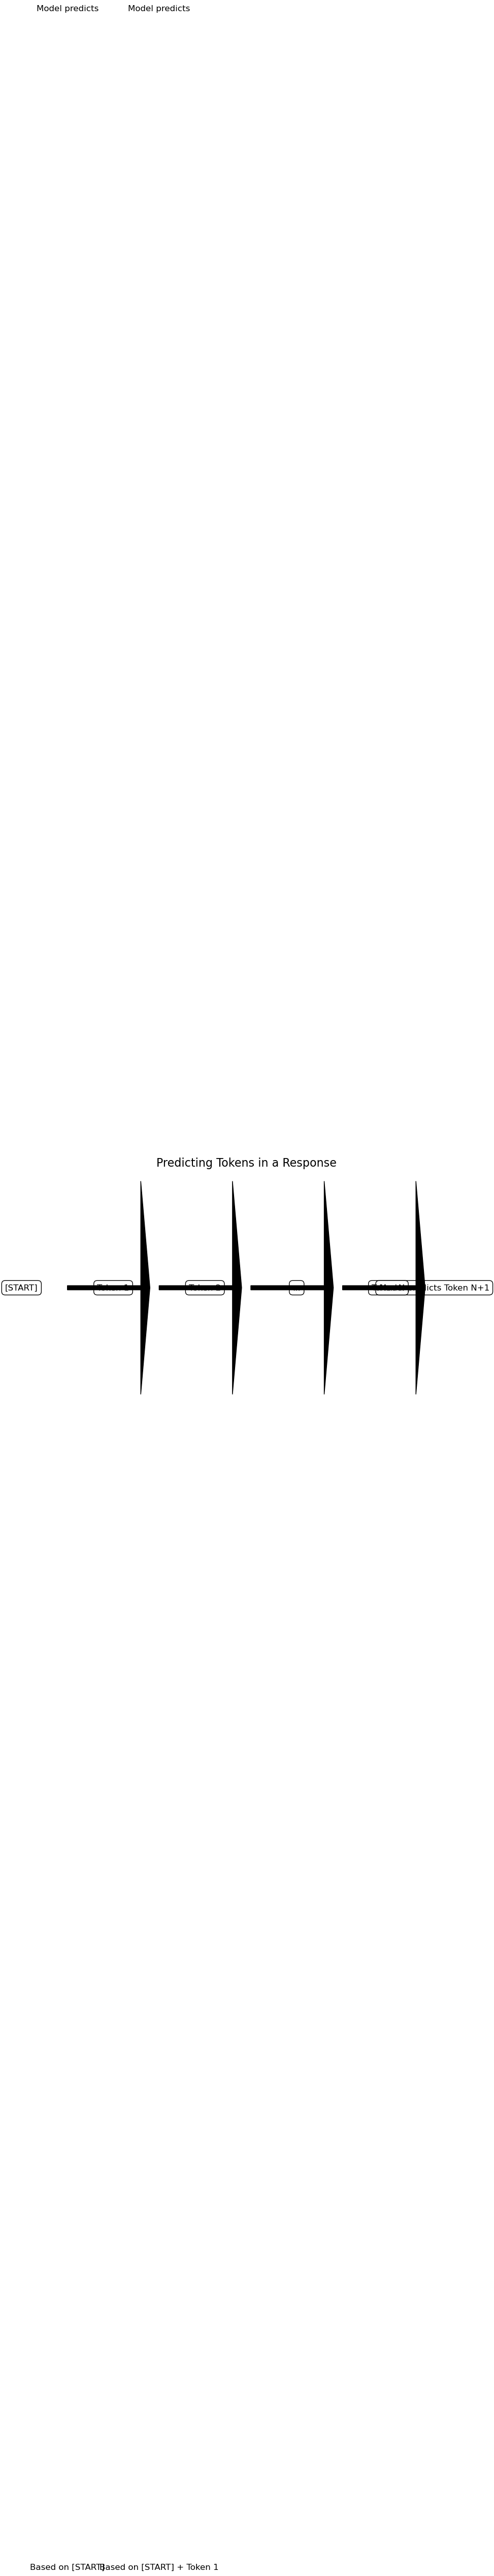

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Settings for visual appearance
plt.figure(figsize=(10, 6))

# Positions of elements
token_positions = np.arange(1, 6)
arrow_positions = token_positions[:-1] + 0.5

# Token labels
tokens = ['[START]', 'Token 1', 'Token 2', '...', 'Token N']

# Draw tokens
for pos, token in zip(token_positions, tokens):
    plt.text(pos, 0.5, token, ha='center', va='center', fontsize=12, bbox=dict(facecolor='none', edgecolor='black', boxstyle='Round,pad=0.4'))

# Draw arrows
for pos in arrow_positions:
    plt.arrow(pos, 0.5, 0.8, 0, head_width=0.05, head_length=0.1, fc='k', ec='k')

# Add annotations
plt.text(1.5, 0.8, 'Model predicts', ha='center', va='center', fontsize=12)
plt.text(1.5, 0.2, 'Based on [START]', ha='center', va='center', fontsize=12)
plt.text(2.5, 0.8, 'Model predicts', ha='center', va='center', fontsize=12)
plt.text(2.5, 0.2, 'Based on [START] + Token 1', ha='center', va='center', fontsize=12)
plt.text(5.5, 0.5, 'Model predicts Token N+1', ha='center', va='center', fontsize=12, bbox=dict(facecolor='none', edgecolor='black', boxstyle='Round,pad=0.4'))

# Add title
plt.title('Predicting Tokens in a Response', fontsize=16)

# Remove axes
plt.axis('off')

plt.show()
